In [1]:
import pandas as pd
import os
from sodapy import Socrata
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import acquire
import prepare
import explore
import wrangle

pd.set_option('display.max_column', None)
# plotting defaults
plt.rc('figure', figsize=(23, 10))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

# Acquire and Prepare the Data
We'll use the wrangle module to acquire and prepare the data in one step

In [2]:
df = wrangle.wrangle_crime_data(drop_cleared_by_exception=True)

Using cached csv


In [3]:
print(df.shape)
df.head()

(348008, 18)


,crime_type,family_violence,occurrence_time,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared,time_to_report
34573,ASSAULT ON PUBLIC SERVANT,N,2021-12-31 23:50:00,2021-12-31,2021-12-31 23:50:00,2021-12-31,COMMERCIAL / OFFICE BUILDING,111 CONGRESS AVE,78701.0,9.0,GE,3,30.263739,-97.743651,cleared by arrest,2022-01-03,True,0 days 00:00:00
34574,THEFT,N,2021-12-31 23:50:00,2021-12-31,2022-01-07 14:12:00,2022-01-07,OTHER / UNKNOWN,6936 E BEN WHITE BLVD SVRD WB,78741.0,3.0,HE,5,30.215264,-97.703019,not cleared,2022-01-10,False,6 days 14:22:00
34575,PUBLIC INTOXICATION,N,2021-12-31 23:50:00,2021-12-31,2021-12-31 23:50:00,2021-12-31,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,406 E 6TH ST,78701.0,9.0,GE,2,30.267300,-97.738857,cleared by arrest,2021-12-31,True,0 days 00:00:00
34576,DOC DISCHARGE GUN - PUB PLACE,N,2021-12-31 23:47:00,2021-12-31,2021-12-31 23:47:00,2021-12-31,RESIDENCE / HOME,1202 E ST JOHNS AVE,78752.0,4.0,ID,1,30.328049,-97.693683,not cleared,2022-01-05,False,0 days 00:00:00
34577,AGG ASLT STRANGLE/SUFFOCATE,Y,2021-12-31 23:40:00,2021-12-31,2022-01-01 00:44:00,2022-01-01,RESIDENCE / HOME,10000 N LAMAR BLVD,78758.0,4.0,ED,1,30.369262,-97.695105,not cleared,2022-01-05,False,0 days 01:04:00


# Explore the Distributions of the Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348008 entries, 34573 to 436548
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   crime_type        348008 non-null  object         
 1   family_violence   348008 non-null  object         
 2   occurrence_time   348008 non-null  datetime64[ns] 
 3   occurrence_date   348008 non-null  datetime64[ns] 
 4   report_time       348008 non-null  datetime64[ns] 
 5   report_date       348008 non-null  datetime64[ns] 
 6   location_type     348008 non-null  object         
 7   address           348008 non-null  object         
 8   zip_code          348008 non-null  float64        
 9   council_district  348008 non-null  float64        
 10  sector            348008 non-null  object         
 11  district          348008 non-null  object         
 12  latitude          348008 non-null  float64        
 13  longitude         348008 non-null  float

In [5]:
# Use .describe with object columns

obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]
obj_cols

for col in obj_cols:
    print(col.upper())
    print('Count:')
    print(df[col].value_counts())
    print('\n')
    print('Proportions:')
    print(df[col].value_counts(normalize=True, dropna=False))
    print('--------------------------')
    print('\n')


CRIME_TYPE
Count:
BURGLARY OF VEHICLE                            34866
THEFT                                          29886
FAMILY DISTURBANCE                             24369
CRIMINAL MISCHIEF                              19334
AUTO THEFT                                     12766
                                               ...  
EXPIRED-DO NOT USE-ASSAULT ON PEACE OFFICER        1
ATT BURGLARY OF RESIDENCE                          1
ABUSE OF CORPSE                                    1
COMMERCIAL BRIBERY                                 1
BAIL JUMPING/FAIL TO APPEAR                        1
Name: crime_type, Length: 340, dtype: int64


Proportions:
BURGLARY OF VEHICLE                            0.100187
THEFT                                          0.085877
FAMILY DISTURBANCE                             0.070024
CRIMINAL MISCHIEF                              0.055556
AUTO THEFT                                     0.036683
                                                 ...   
EXPI

# Split the Data for Exploratation

In [6]:
train, validate, test = prepare.split_data(df)
train.shape, validate.shape, test.shape

((194884, 18), (83522, 18), (69602, 18))

In [7]:
train_copy = train.copy()

# Copy of Train and adding GeoPandas

In [8]:
#Assign my .shp file to a variable named “asutin_map”
austin_map = gpd.read_file('Boundaries_zipcode/geo_export_9b5aa23d-57b1-41f4-b4f9-0a9d97fac540.shp')

In [9]:
austin_map = austin_map.drop(columns =['affgeoid10','geoid10','aland10','awater10'])

In [10]:
austin_map = austin_map.rename(columns ={'zcta5ce10': 'zip_code'})
austin_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zip_code  54 non-null     object  
 1   geometry  54 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 992.0+ bytes


In [11]:
austin_map['zip_code'] = austin_map.zip_code.astype('float64')

In [12]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194884 entries, 226391 to 212383
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   crime_type        194884 non-null  object         
 1   family_violence   194884 non-null  object         
 2   occurrence_time   194884 non-null  datetime64[ns] 
 3   occurrence_date   194884 non-null  datetime64[ns] 
 4   report_time       194884 non-null  datetime64[ns] 
 5   report_date       194884 non-null  datetime64[ns] 
 6   location_type     194884 non-null  object         
 7   address           194884 non-null  object         
 8   zip_code          194884 non-null  float64        
 9   council_district  194884 non-null  float64        
 10  sector            194884 non-null  object         
 11  district          194884 non-null  object         
 12  latitude          194884 non-null  float64        
 13  longitude         194884 non-null  floa

In [13]:
#create a new dataframe with both our geographical and statistical data in it by merging our two tables together.
new_df = austin_map.merge(df, on ='zip_code')

In [14]:
new_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 348001 entries, 0 to 348000
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   zip_code          348001 non-null  float64        
 1   geometry          348001 non-null  geometry       
 2   crime_type        348001 non-null  object         
 3   family_violence   348001 non-null  object         
 4   occurrence_time   348001 non-null  datetime64[ns] 
 5   occurrence_date   348001 non-null  datetime64[ns] 
 6   report_time       348001 non-null  datetime64[ns] 
 7   report_date       348001 non-null  datetime64[ns] 
 8   location_type     348001 non-null  object         
 9   address           348001 non-null  object         
 10  council_district  348001 non-null  float64        
 11  sector            348001 non-null  object         
 12  district          348001 non-null  object         
 13  latitude          348001 non-null  f

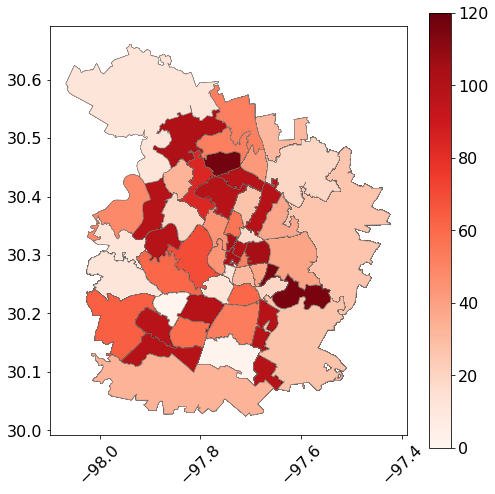

In [15]:
#Crime_type by zip_code
fig, ax = plt.subplots(1, figsize=(8, 8))
plt.xticks(rotation=45)
new_df.plot(column="crime_type", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")
bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=120))
bar_info._A = []
cbar = fig.colorbar(bar_info)

# Continuing exploration on Train

In [16]:
train[train.crime_type == 'PUBLIC INTOXICATION'].council_district.value_counts()

9.0     650
3.0     352
4.0     245
1.0     202
7.0     196
5.0     131
2.0     121
6.0      81
10.0     53
8.0      31
Name: council_district, dtype: int64

In [17]:
train[train.family_violence == 'True'].cleared.value_counts()

Series([], Name: cleared, dtype: int64)

## crime type exploration

- murders - 85 total, 8 capital murders in set the rest are murders
- 2061 public intoxications
- 15.5k family violence reports

In [18]:
train.family_violence.value_counts()

N    179373
Y     15511
Name: family_violence, dtype: int64

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194884 entries, 226391 to 212383
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   crime_type        194884 non-null  object         
 1   family_violence   194884 non-null  object         
 2   occurrence_time   194884 non-null  datetime64[ns] 
 3   occurrence_date   194884 non-null  datetime64[ns] 
 4   report_time       194884 non-null  datetime64[ns] 
 5   report_date       194884 non-null  datetime64[ns] 
 6   location_type     194884 non-null  object         
 7   address           194884 non-null  object         
 8   zip_code          194884 non-null  float64        
 9   council_district  194884 non-null  float64        
 10  sector            194884 non-null  object         
 11  district          194884 non-null  object         
 12  latitude          194884 non-null  float64        
 13  longitude         194884 non-null  floa

In [20]:
train.council_district.value_counts()

9.0     31571
3.0     28876
4.0     27178
7.0     22287
1.0     21768
2.0     18436
5.0     15892
6.0     11606
10.0     8941
8.0      8329
Name: council_district, dtype: int64

### General takeaways
- total of 195K rows of crime
- district 9 has highest count at 31k
    - UT campus, 6th Street, Rainey Street, capital
- district 3/4 have roughly the same at 28k
    - district 3 - ladybird lake, ACC
- district 7/1 have 22k each of crime
- district 2/5 have about 17k
- district 6/10/8 have the lowest counts by far
    - 'west' austin, more on the outskirts
    - district 8 - zilker park, barton springs pool
    - district 10 - lake travis, westlake
    - district 6 - borders cedar park
    
- Seasonality
- SXSW - March
- ACL - October
- School - STARTS late August | ENDS Early December
            STARTS early January | ENDS Late May


#### What kind of crime is in each district?

In [21]:
train.council_district.value_counts()

9.0     31571
3.0     28876
4.0     27178
7.0     22287
1.0     21768
2.0     18436
5.0     15892
6.0     11606
10.0     8941
8.0      8329
Name: council_district, dtype: int64

In [22]:
one = train[train.council_district == 1]
two = train[train.council_district == 2]
three = train[train.council_district == 3]
four = train[train.council_district == 4]
five = train[train.council_district == 5]
six = train[train.council_district == 6]
seven = train[train.council_district == 7]
eight = train[train.council_district == 8]
nine = train[train.council_district == 9]
ten = train[train.council_district == 10]


one.shape, two.shape, three.shape, four.shape, five.shape, six.shape, seven.shape, eight.shape, nine.shape, ten.shape

((21768, 18),
 (18436, 18),
 (28876, 18),
 (27178, 18),
 (15892, 18),
 (11606, 18),
 (22287, 18),
 (8329, 18),
 (31571, 18),
 (8941, 18))

In [23]:
# district 9 has the most crime
nine.crime_type.value_counts()

BURGLARY OF VEHICLE              3123
THEFT                            3049
ASSAULT BY CONTACT               1646
CRIMINAL MISCHIEF                1636
ASSAULT WITH INJURY              1451
                                 ... 
FICTITIOUS NAME                     1
VIOL OF PARK CURFEW                 1
PERJURY                             1
ENGAGING IN ORGANIZED CRIME         1
AGG PROMOTION OF PROSTITUTION       1
Name: crime_type, Length: 248, dtype: int64

In [24]:
# district 3 is also in downtown, looking at the crime type
three.crime_type.value_counts()

BURGLARY OF VEHICLE             2569
THEFT                           2500
FAMILY DISTURBANCE              1986
CRIMINAL MISCHIEF               1580
AUTO THEFT                      1109
                                ... 
MANSLAUGHTER                       1
OFFICIAL OPPRESSION                1
EXPLOSIVE ORDNANCE DISPOSAL        1
THEFT BY FALSE PRETEXT/BUNCO       1
POCKET PICKING                     1
Name: crime_type, Length: 238, dtype: int64

In [25]:
# district 8 is west austin, looking at crime type
eight.crime_type.value_counts()

BURGLARY OF VEHICLE               1200
THEFT                              886
FAMILY DISTURBANCE                 395
CRIMINAL MISCHIEF                  355
THEFT BY SHOPLIFTING               353
                                  ... 
UNLAWFUL INTERCEPTION                1
TOBACCO VIOL - UNDER AGE 21          1
POSS OF ALCOHOL-AGE 16 & UNDER       1
FALSE STATEMENT -OBTAIN CREDIT       1
HARASSMENT OF A PUBLIC SERVANT       1
Name: crime_type, Length: 184, dtype: int64

In [26]:
# district 10 is more closer to lake travis, second lowest crime count
ten.crime_type.value_counts()

BURGLARY OF VEHICLE              1842
THEFT                             744
CRIMINAL MISCHIEF                 465
FAMILY DISTURBANCE                459
IDENTITY THEFT                    372
                                 ... 
MISUSE OF OFFICIAL INFO             1
AGG ASSAULT ON PUBLIC SERVANT       1
PROWLER                             1
DOC DISCHARGE GUN - PUB ROAD        1
WEAPON VIOL - OTHER                 1
Name: crime_type, Length: 184, dtype: int64

## Districts and their level of crime in descending order
### Questions for Ryan
- What does it mean for the case to not be cleared
-- not cleared means charge has not been given yet. not enough evidence to be charged
-- cleared by exception doesn't mean it was ended in arrest. person could have died
-- cleared by arrest
- Did he notice seasonality trends
- pre/post covid numbers
-- family violence pre and post pandemic
-- what days are higher in family violence
- single incident top charge
-- 

In [27]:
train.groupby('family_violence').crime_type.value_counts()

family_violence  crime_type                  
N                BURGLARY OF VEHICLE             19741
                 THEFT                           16470
                 FAMILY DISTURBANCE              13624
                 CRIMINAL MISCHIEF               10799
                 AUTO THEFT                       7057
                                                 ...  
Y                POSS/PROMO CHILD PORNOGRAPHY        1
                 PUBLIC INTOXICATION                 1
                 ROBBERY BY THREAT                   1
                 THEFT FROM AUTO                     1
                 THEFT FROM BUILDING                 1
Name: crime_type, Length: 392, dtype: int64

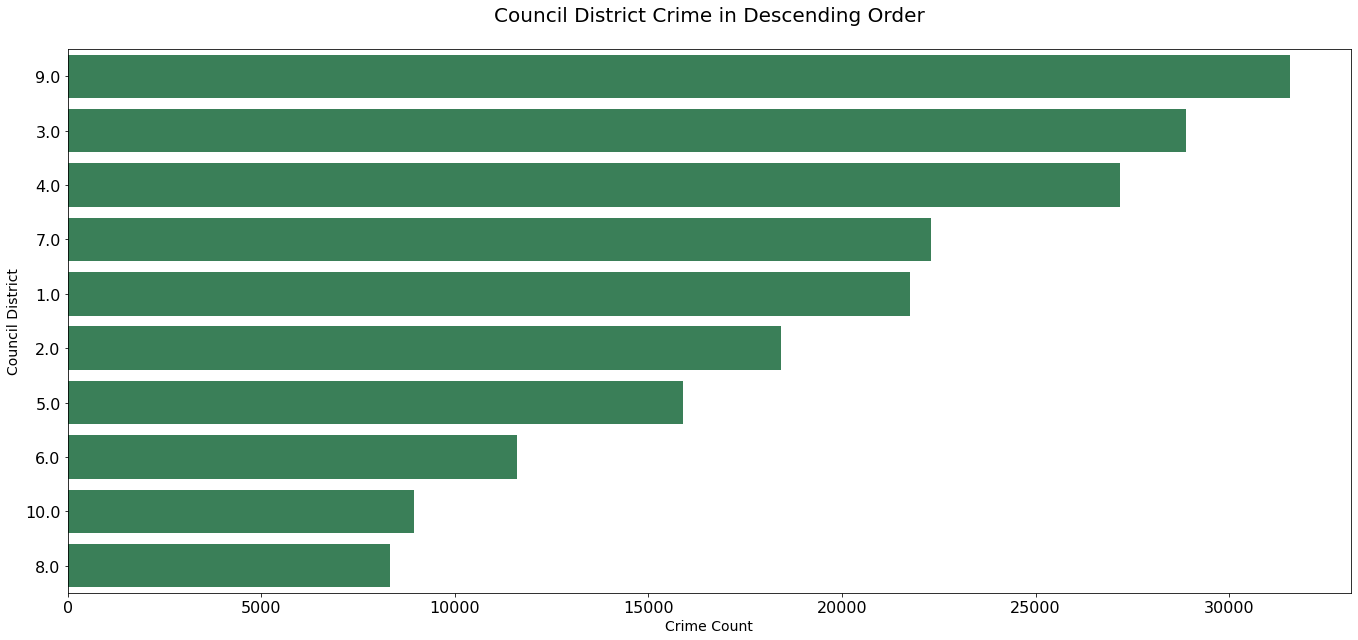

In [28]:
def council_district_crime(train):
    '''
    This function will take in the train dataset and return a seaborn 
    visual of the council district and their crime count in descending order
    '''
    ax = sns.countplot(data = train, y = 'council_district',order = train['council_district'].value_counts(ascending = False).index, color = 'seagreen')
    plt.xlabel('Crime Count',fontsize=14)# set up the x axis. 
    plt.ylabel('Council District',fontsize=14)# set up the y axis
    plt.title('Council District Crime in Descending Order\n',fontsize=20) # set up the title.
    plt.show()

    return

council_district_crime(train)

In [29]:
train.district.value_counts()

2     38700
1     36630
3     23700
4     23465
5     20022
7     19328
6     18594
8     13176
S       539
88      360
D       218
B        61
A        37
P        34
C        20
Name: district, dtype: int64

In [30]:
def district_crime(train):
    """
    This function is to create a visual to show all districts in descending order. 
    """
    # creating district crime frequency (horizontal)

    train.district.value_counts(ascending = True, normalize = False).plot.barh(color = 'orange',figsize = (12, 7))
    # adding title
    plt.xlabel('Crime Count',fontsize=12)# set up the x axis. 
    plt.ylabel('District',fontsize=12)# set up the y axis
    plt.title('District Crime in Descending Order\n',fontsize=15) # set up the title.
    plt.show()


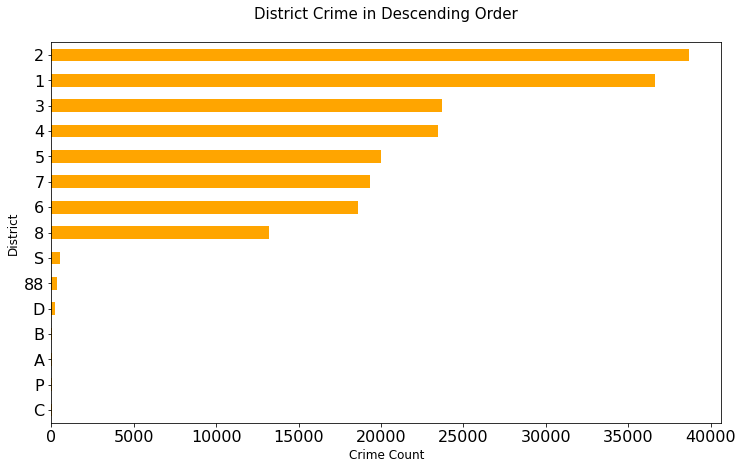

In [31]:
district_crime(train)

In [32]:
train[train.crime_type == 'MURDER'].value_counts().sum()

67

In [33]:
train.groupby('district').cleared.value_counts()

district  cleared
1         False      28523
          True        8107
2         False      28822
          True        9878
3         False      19015
          True        4685
4         False      18767
          True        4698
5         False      16051
          True        3971
6         False      15305
          True        3289
7         False      16181
          True        3147
8         False      10718
          True        2458
88        False        237
          True         123
A         False         26
          True          11
B         False         53
          True           8
C         False         14
          True           6
D         False        186
          True          32
P         False         32
          True           2
S         False        393
          True         146
Name: cleared, dtype: int64

In [34]:
top_10_crimes = ['DWI', 'ASSAULT WITH INJURY', 'THEFT BY SHOPLIFTING', 'HARASSMENT', 
                 'AUTO THEFT', 'ASSAULT W/INJURY-FAM/DATE VIOL', 'CRIMINAL MISCHIEF', 
                 'FAMILY DISTURBANCE', 'THEFT', 'BURGLARY OF VEHICLE']
# Create a subsetted df that only includes the top 10 crimes
top_crimes_df = train.copy()
top_crimes_df = top_crimes_df[top_crimes_df.crime_type.isin(top_10_crimes)]

In [35]:
def top_crime(top_crimes_df):
    """
    This function is to create a visual to show all districts in descending order. 
    """
    # creating district crime frequency (horizontal)

    top_crimes_df.council_district.value_counts(ascending = True, normalize = False).plot.barh(color = 'blue',figsize = (12, 7))
    # adding title
    plt.xlabel('Crime Count',fontsize=12)# set up the x axis. 
    plt.ylabel('Council District',fontsize=12)# set up the y axis
    plt.title('Council District Crime in Descending Order\n',fontsize=15) # set up the title.
    plt.show()

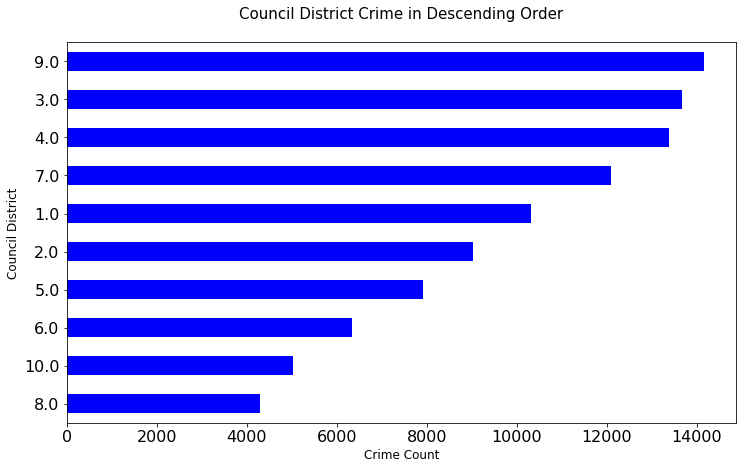

In [36]:
top_crime(top_crimes_df)

### Takeaway
- It seems that districts 9, 3 and 4 are much higher in crime compared to the other districts

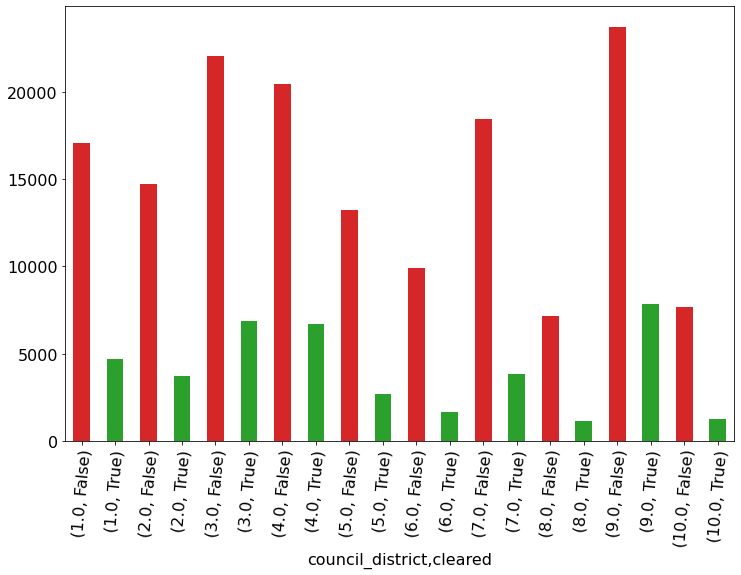

In [37]:
train.groupby('council_district').cleared.value_counts().plot.bar(figsize = (12, 8), color = ['#d62728', '#2ca02c'])
plt.tick_params('x' ,rotation = 85)

In [38]:
train.head()

,crime_type,family_violence,occurrence_time,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared,time_to_report
226391,THEFT OF SERVICE,N,2020-01-09 02:26:00,2020-01-09,2020-01-09 02:26:00,2020-01-09,PARKING /DROP LOT/ GARAGE,6906 GUADALUPE ST,78752.0,4.0,ID,8,30.335585,-97.716224,cleared by arrest,2020-01-09,True,0 days 00:00:00
266878,FAMILY DISTURBANCE,N,2019-08-23 19:13:00,2019-08-23,2019-08-23 19:13:00,2019-08-23,RESIDENCE / HOME,907 AIROSO CV,78745.0,2.0,FR,4,30.206636,-97.787635,not cleared,2020-03-10,False,0 days 00:00:00
328590,THEFT,N,2019-01-24 14:07:00,2019-01-24,2019-01-24 15:56:00,2019-01-24,DEPARTMENT / DISCOUNT STORE,1030 NORWOOD PARK BLVD,78753.0,4.0,ID,2,30.339152,-97.691166,cleared by arrest,2019-02-04,True,0 days 01:49:00
187102,FRAUD - OTHER,N,2020-05-29 13:00:00,2020-05-29,2020-05-29 15:16:00,2020-05-29,RESTAURANT,10515 N MOPAC EXPY SVRD NB,78759.0,7.0,AD,1,30.391604,-97.732448,not cleared,2020-06-15,False,0 days 02:16:00
285600,FAMILY DISTURBANCE,N,2019-06-22 03:54:00,2019-06-22,2019-06-22 03:54:00,2019-06-22,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,E 11TH ST / RED RIVER ST,78701.0,1.0,GE,1,30.271169,-97.735451,not cleared,2019-08-30,False,0 days 00:00:00


<AxesSubplot:xlabel='council_district'>

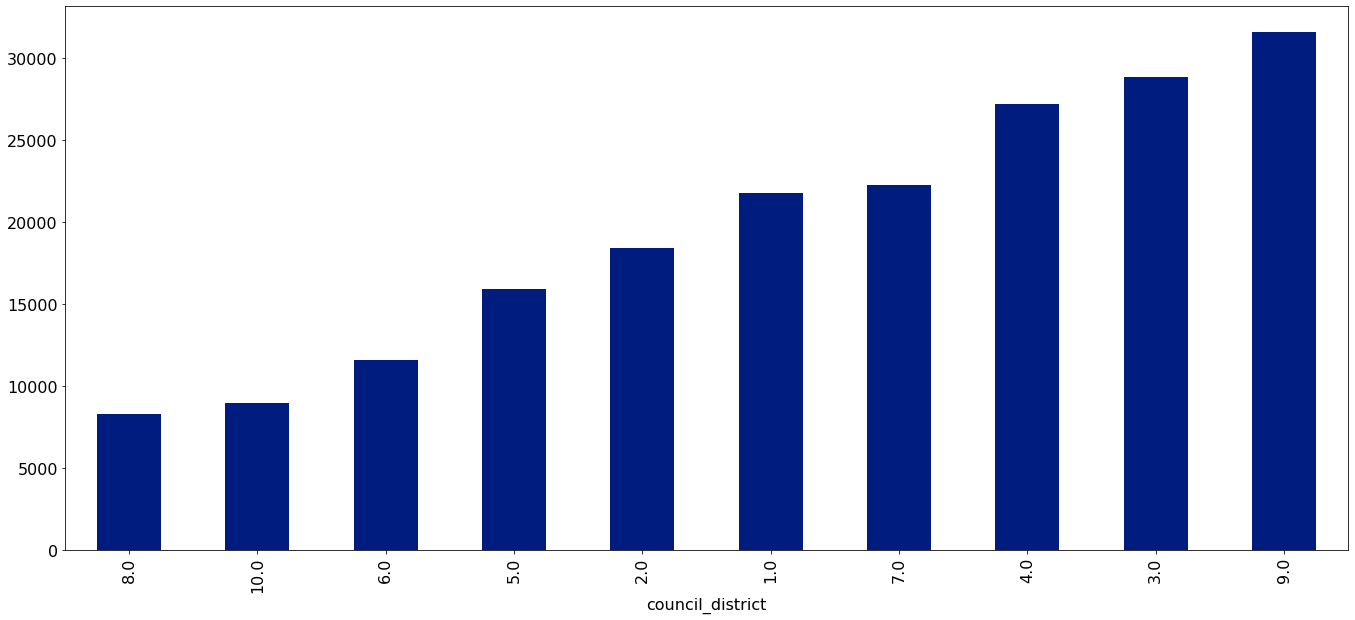

In [39]:
train.groupby(train.council_district).crime_type.count().sort_values().plot.bar()

hard to solve
- family disturbance
- disturbance


more solvable
- auto theft (possible)
- assault with injury
- dwi
- 

topics of discussion
- hardening targets ( proper lighting, dog in yard )

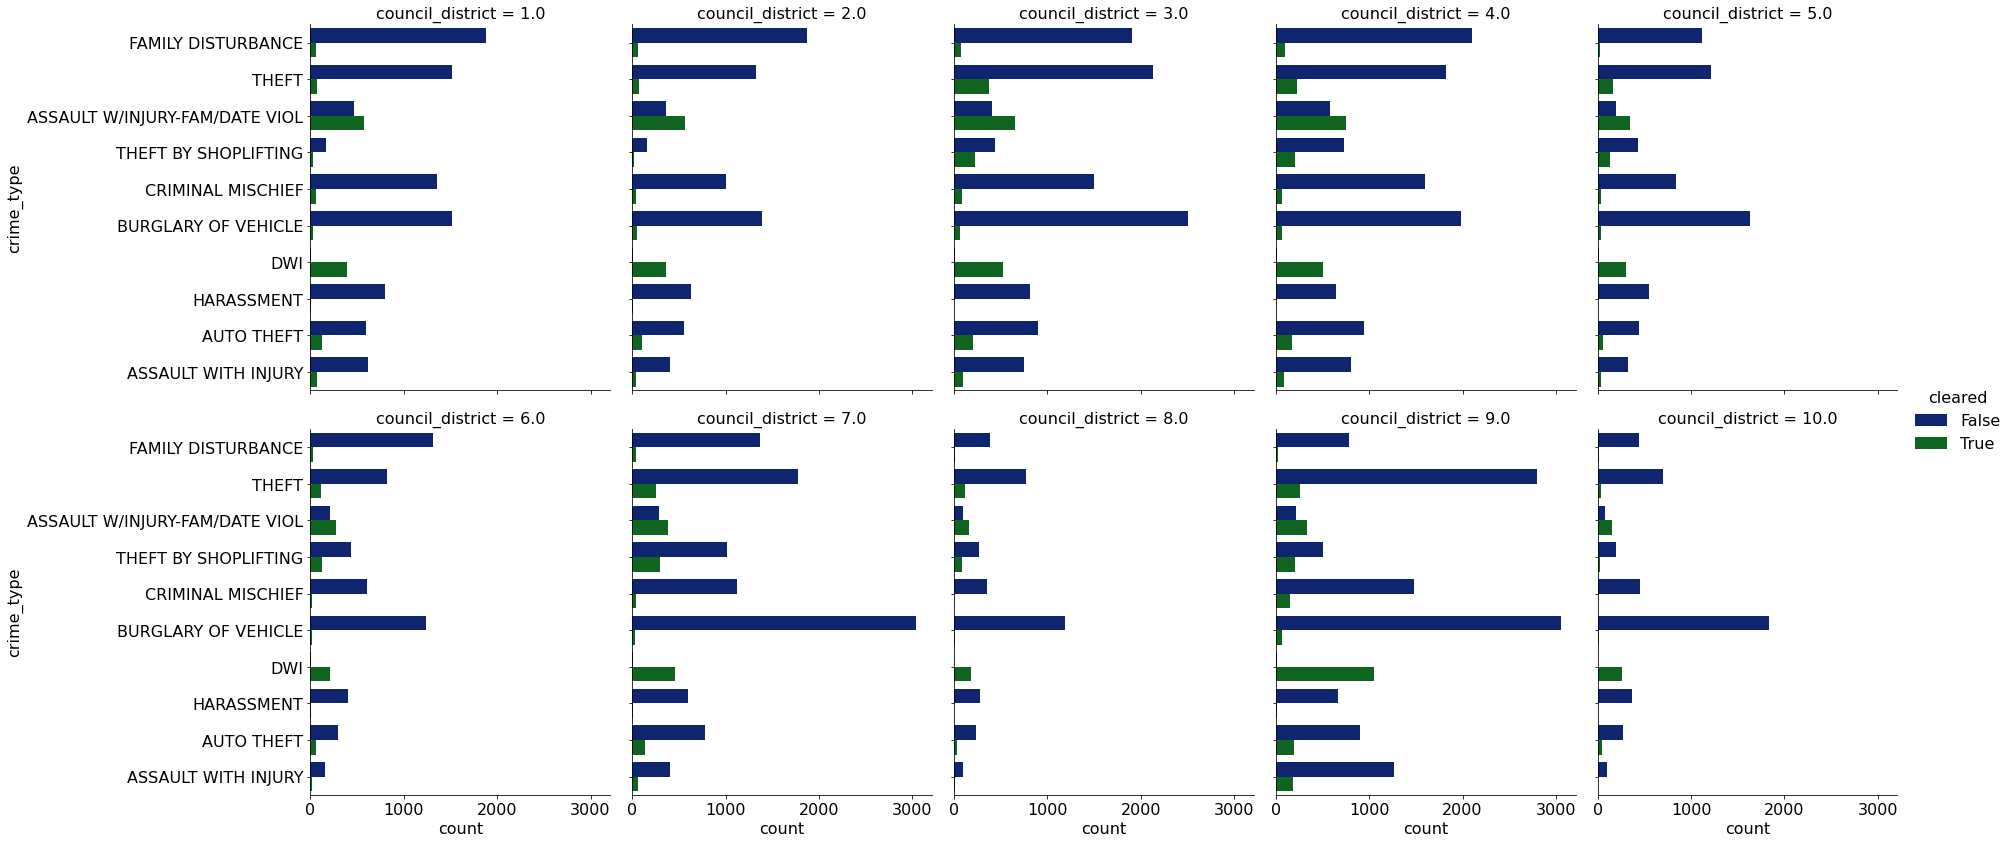

In [40]:
#define plotting region (2 rows, 5 columns)
# fig, axes = plt.subplots(2, 5)

sns.catplot(y="crime_type", hue="cleared", col="council_district",
              data=top_crimes_df, kind="count",
                height=6, aspect=.9, col_wrap = 5);


In [41]:
train.groupby('council_district').cleared.value_counts()

council_district  cleared
1.0               False      17048
                  True        4720
2.0               False      14692
                  True        3744
3.0               False      22019
                  True        6857
4.0               False      20459
                  True        6719
5.0               False      13203
                  True        2689
6.0               False       9911
                  True        1695
7.0               False      18425
                  True        3862
8.0               False       7167
                  True        1162
9.0               False      23705
                  True        7866
10.0              False       7694
                  True        1247
Name: cleared, dtype: int64

In [42]:
train.cleared.mean()

0.2081289382401839

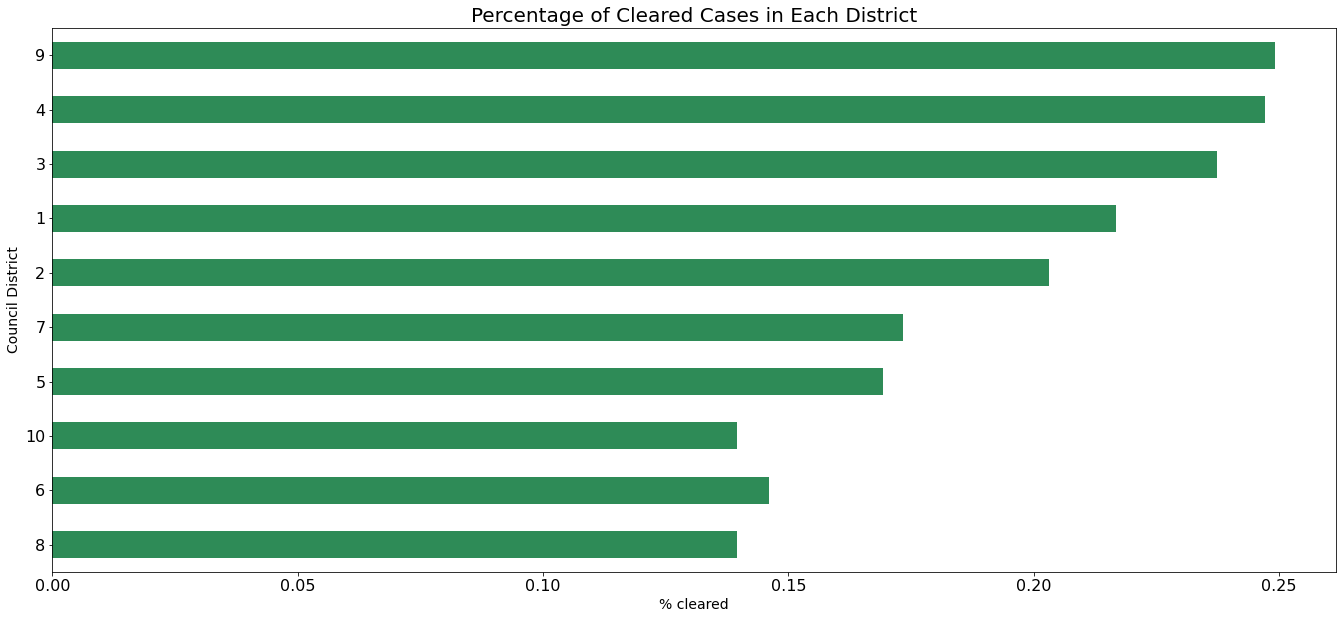

In [43]:
def district_cleared(train):
    index = [8,6,10,5,7,2,1,3,4,9]
    df1 = pd.DataFrame(train.groupby('council_district').cleared.mean(), index = index)
    ax = df1.plot.barh(color = 'seagreen')
    plt.ylabel('Council District', fontsize = 14)
    plt.xlabel('% cleared', fontsize = 14)
    plt.title('Percentage of Cleared Cases in Each District', fontsize = 20)
    ax.get_legend().remove()
    return 
district_cleared(train)

def patrol_area_cleared(train):
    
    df1 = pd.DataFrame(train.groupby('patrol_area').cleared.mean().sort_values())
    ax = df1.plot.barh(color = 'seagreen')
    plt.ylabel('Council District', fontsize = 14)
    plt.xlabel('% cleared', fontsize = 14)
    plt.title('Percentage of Cleared Cases in Each District', fontsize = 20)
    ax.get_legend().remove()
    ax.axvline(train.cleared.mean())
    return 
patrol_area_cleared(train)

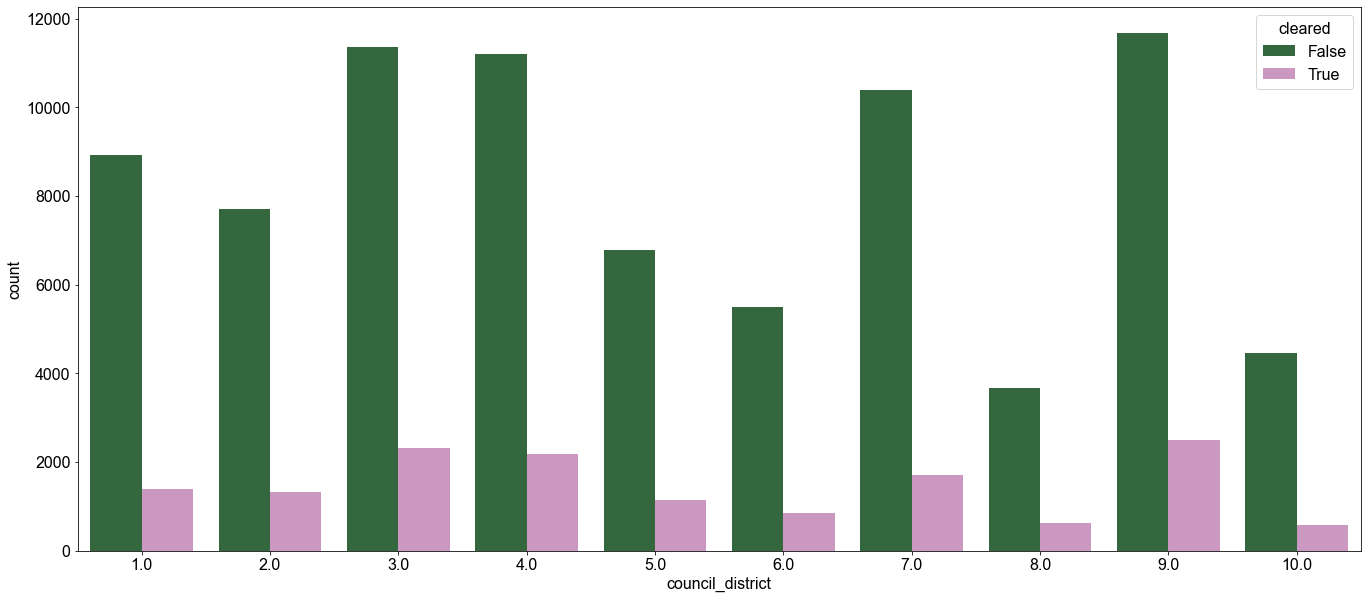

In [45]:
def top_crime_per_district_cleared(train):
    sns.countplot(data = top_crimes_df, x = 'council_district', hue = 'cleared', palette = 'cubehelix')
    sns.set(rc={'figure.figsize':(14, 8)})
    return
top_crime_per_district_cleared(train)

In [46]:
top_five = train.crime_type.head(5)
top_five.head()

226391      THEFT OF SERVICE
266878    FAMILY DISTURBANCE
328590                 THEFT
187102         FRAUD - OTHER
285600    FAMILY DISTURBANCE
Name: crime_type, dtype: object

In [47]:
overall_sample = train.groupby('council_district').council_district.count().mean()
nine_sample = train[train.council_district == 9].count()
eight_sample = train[train.council_district == 8].count()
overall_sample, nine_sample, eight_sample

(19488.4,
 crime_type          31571
 family_violence     31571
 occurrence_time     31571
 occurrence_date     31571
 report_time         31571
 report_date         31571
 location_type       31571
 address             31571
 zip_code            31571
 council_district    31571
 sector              31571
 district            31571
 latitude            31571
 longitude           31571
 clearance_status    31571
 clearance_date      31571
 cleared             31571
 time_to_report      31571
 dtype: int64,
 crime_type          8329
 family_violence     8329
 occurrence_time     8329
 occurrence_date     8329
 report_time         8329
 report_date         8329
 location_type       8329
 address             8329
 zip_code            8329
 council_district    8329
 sector              8329
 district            8329
 latitude            8329
 longitude           8329
 clearance_status    8329
 clearance_date      8329
 cleared             8329
 time_to_report      8329
 dtype: int64)

# Stats
### District 9 one sample ttest

- H0: The average caseload in District 9 <= The average caseload of cases of ALL Districts
- Ha: The average caseload in District 9 > The average caseload of cases of ALL Districts

In [48]:
alpha = .05
t, p = stats.ttest_1samp(nine_sample, overall_sample)

print(t, p/2, alpha)

inf 0.0 0.05


In [49]:
if p/2 > alpha:
    print("We fail to reject Null Hypothesis")
elif t < 0:
    print("We fail to reject Null Hypothesis")
else:
    print("We reject Null Hypothesis")

We reject Null Hypothesis


### District 8 one sample ttest

- H0: The average caseload in District 8 >= The average caseload of cases of ALL Districts
- Ha: The average caseload in District 8 < The average caseload of cases of ALL Districts

In [50]:
alpha = .05
t, p = stats.ttest_1samp(eight_sample, overall_sample)

print(t, p/2, alpha)

-inf 0.0 0.05


In [51]:
if p/2 > alpha:
    print("We fail to reject Null Hypothesis")
elif t > 0:
    print("We fail to reject Null Hypothesis")
else:
    print("We reject Null Hypothesis")

We reject Null Hypothesis


# Zipcodes

In [52]:
def lower_zipcode_crime(train):
    """
    This function is to create a visual to show all districts in descending order. 
    """
    # creating district crime frequency (horizontal)

    train.zip_code.value_counts(ascending = True, normalize = False).tail(10).plot.barh(color = 'red',figsize = (12, 7))
    # adding title
    plt.xlabel('Crime Count',fontsize=12)# set up the x axis. 
    plt.ylabel('Zipcode',fontsize=12)# set up the y axis
    plt.title('Highest Reported Zipcodes\n',fontsize=15) # set up the title.
    plt.show()

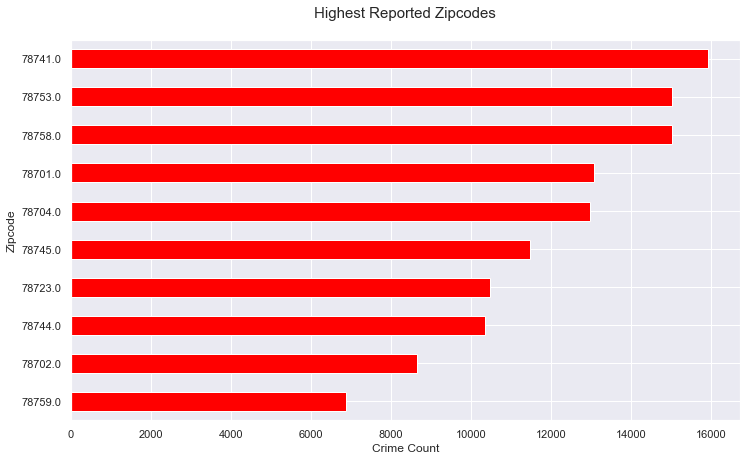

In [53]:
lower_zipcode_crime(train)

In [54]:
def upper_zipcode_crime(train):
    """
    This function is to create a visual to show top 10 safest zipcodes in descending order. 
    """
    # creating district crime frequency (horizontal)

    train.zip_code.value_counts(ascending = True, normalize = False).head(10).plot.barh(color = 'green',figsize = (12, 7))
    # adding title
    plt.xlabel('Crime Count',fontsize=12)# set up the x axis. 
    plt.ylabel('Zipcode',fontsize=12)# set up the y axis
    plt.title('Least Reported Zipcodes\n',fontsize=15) # set up the title.
    plt.show()

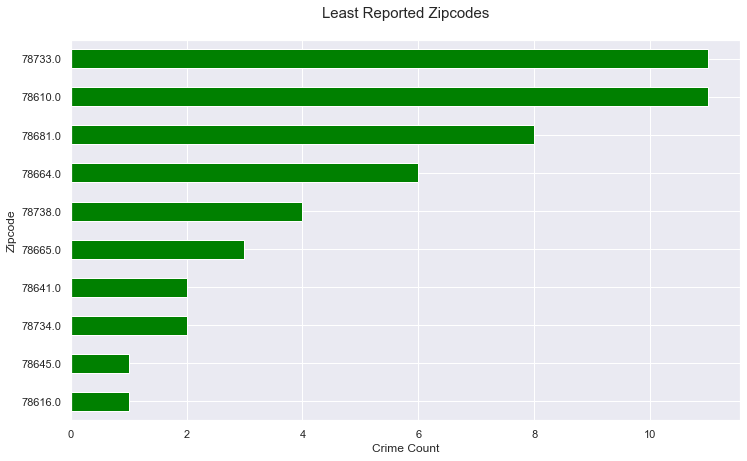

In [55]:
upper_zipcode_crime(train)

# Seasonality of clearance status


In [56]:
time_series = train.copy()
time_series= time_series.set_index('occurrence_time').sort_index()
time_series.shape

(194884, 17)

In [57]:
time_series['month'] = time_series.index.month_name()
time_series['day'] = time_series.index.day_name()
time_series['year'] = time_series.index.year

<AxesSubplot:ylabel='year,clearance_status'>

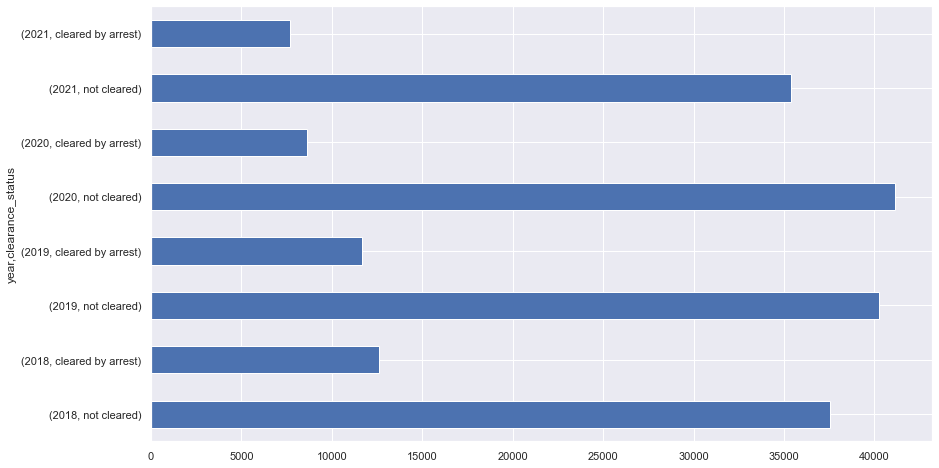

In [96]:
time_series.groupby( 'year').clearance_status.value_counts().plot.barh()

# District exploration
- Looking into police department district and what their clearance status looks like

In [69]:
district_data = wrangle.wrangle_merged_df(drop_columns = True)
district_data.shape

Using cached csv


(352931, 26)

In [70]:
train1, validate1, test1 = prepare.split_data(district_data)
train1.shape, validate1.shape, test1.shape

((197640, 26), (84704, 26), (70587, 26))

In [71]:
train2 = train1.copy()
train2 = train1.set_index('occurrence_time').sort_index()
train2.shape

(197640, 25)

In [72]:
train2['month'] = train2.index.month_name()
train2['day'] = train2.index.day_name()
train2['year'] = train2.index.year

In [111]:
train2.groupby('patrol_area').clearance_status.value_counts().sum()

197640

In [74]:
train2.head()

,crime_type,family_violence,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,latitude,longitude,clearance_status,clearance_date,cleared,time_to_report,the_geom,district_name,battalion_id,code,battalion_code,bureau_name,patrol_area,shape_area,shape_length,month,day,year
occurrence_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,THEFT OF SERVICE,N,2018-01-01,2018-08-23 13:30:00,2018-08-23,RESIDENCE / HOME,12005 ROTHERHAM DR,78753.0,1.0,EDWARD,30.381374,-97.657214,not cleared,2018-10-23,False,234 days 13:30:00,MULTIPOLYGON (((-97.652442658383 30.3876563065...,EDWARD 7,174,1291,E1,CENTRAL,NORTHEAST,7.910069e+07,46998.269790,January,Monday,2018
2018-01-01,BURGLARY NON RESIDENCE,N,2018-01-01,2019-01-04 17:42:00,2019-01-04,OTHER / UNKNOWN,8101 N LAMAR BLVD NB,78753.0,4.0,EDWARD,30.349433,-97.710191,not cleared,2019-02-14,False,368 days 17:42:00,MULTIPOLYGON (((-97.694118479216 30.3826672092...,EDWARD 1,174,1288,E1,CENTRAL,NORTHEAST,8.356489e+07,46296.345268,January,Monday,2018
2018-01-01,HARASSMENT,N,2018-01-01,2018-06-12 20:33:00,2018-06-12,RESIDENCE / HOME,420 W SLAUGHTER LN,78748.0,2.0,FRANK,30.172125,-97.797176,not cleared,2018-06-13,False,162 days 20:33:00,MULTIPOLYGON (((-97.770470420911 30.1904609605...,FRANK 3,184,1293,F1,SOUTH,SOUTHEAST,1.096128e+08,43898.041982,January,Monday,2018
2018-01-01,CRIMINAL MISCHIEF,N,2018-01-01,2018-01-04 16:09:00,2018-01-04,RESIDENCE / HOME,12817 SEXSON RIDGE CV,78617.0,2.0,HENRY,30.174692,-97.618642,not cleared,2018-01-29,False,3 days 16:09:00,MULTIPOLYGON (((-97.613292937491 30.1465468344...,HENRY 7,205,1303,H1,SOUTH,SOUTHCENTRAL,5.035645e+07,61585.792858,January,Monday,2018
2018-01-01,CRIMINAL MISCHIEF,N,2018-01-01,2018-01-04 16:09:00,2018-01-04,RESIDENCE / HOME,12817 SEXSON RIDGE CV,78617.0,2.0,HENRY,30.174692,-97.618642,not cleared,2018-01-29,False,3 days 16:09:00,MULTIPOLYGON (((-97.635913438332 30.1877970633...,HENRY 7,205,1303,H1,SOUTH,SOUTHCENTRAL,8.943496e+07,137659.942768,January,Monday,2018


In [118]:
train2.crime_type.value_counts().sort_values()

ATT BURGLARY OF RESIDENCE                          1
EXPIRED-DO NOT USE-ASSAULT ON PEACE OFFICER        1
FRAUD FILING FINANCE STATEMENT                     1
DEL OF ALCOHOL TO MINOR                            1
SALE OF DXM TO MINOR                               1
                                               ...  
AUTO THEFT                                      7279
CRIMINAL MISCHIEF                              11103
FAMILY DISTURBANCE                             14055
THEFT                                          16662
BURGLARY OF VEHICLE                            19665
Name: crime_type, Length: 319, dtype: int64

<AxesSubplot:xlabel='patrol_area'>

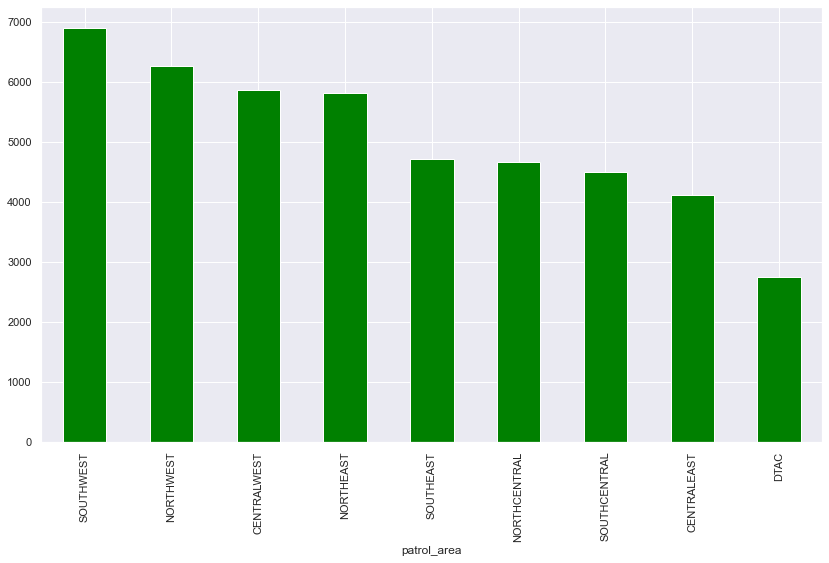

In [117]:
theft = train2[train2.crime_type.str.contains('THEFT')]

theft.groupby('patrol_area').crime_type.count().sort_values(ascending = False).plot.bar(color = 'green')

<AxesSubplot:xlabel='patrol_area'>

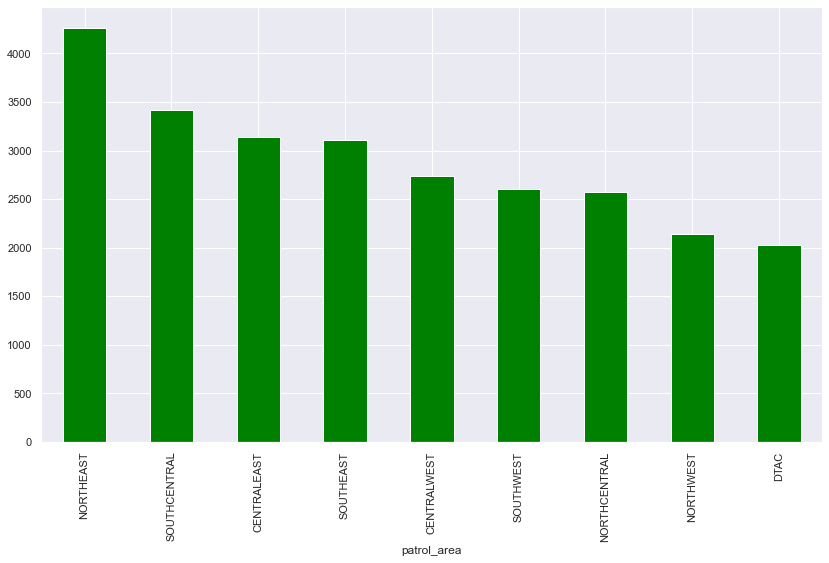

In [116]:
assault = train2[train2.crime_type.str.contains('ASSAULT')]

assault.groupby('patrol_area').crime_type.count().sort_values(ascending = False).plot.bar(color = 'green')

<AxesSubplot:xlabel='patrol_area'>

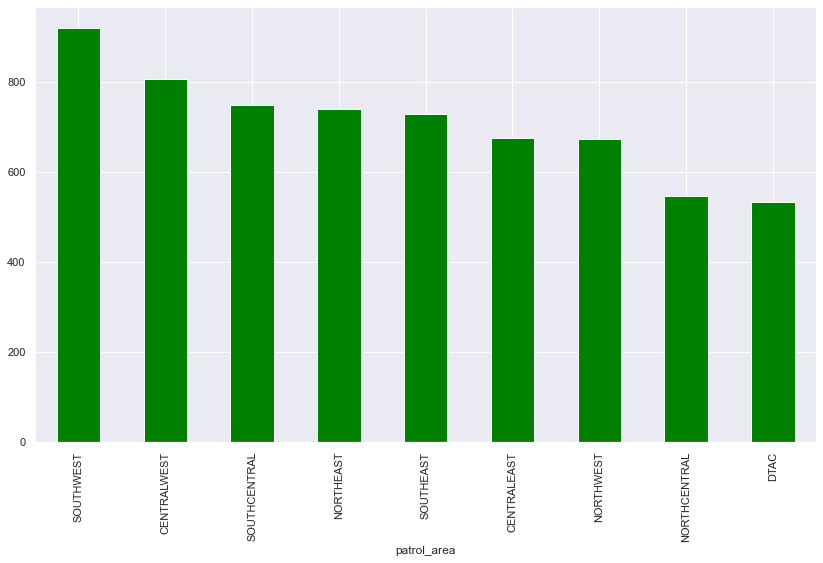

In [115]:
dwi = train2[train2.crime_type.str.contains('DWI')]

dwi.groupby('patrol_area').crime_type.count().sort_values(ascending = False).plot.bar(color = 'green')

<AxesSubplot:xlabel='patrol_area'>

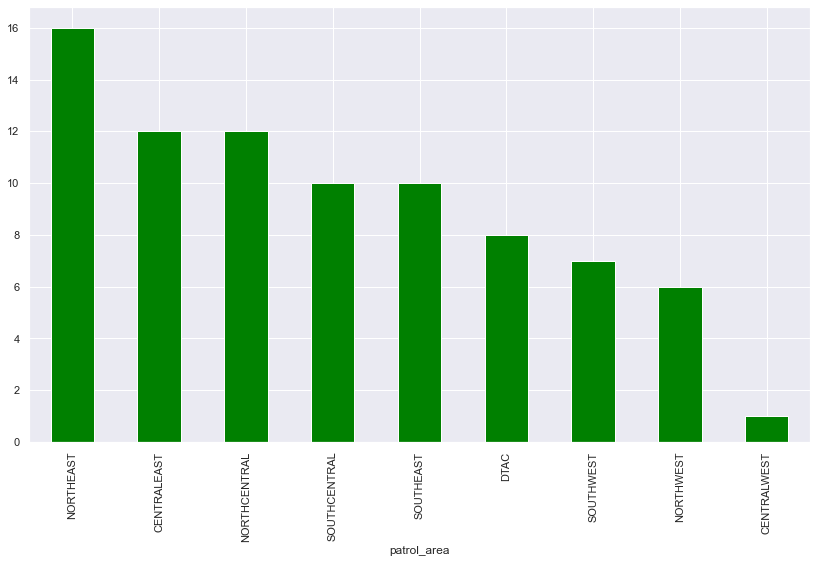

In [97]:

murder = train2[train2.crime_type.str.contains('MURDER')]

murder.groupby('patrol_area').crime_type.count().sort_values(ascending = False).plot.bar(color = 'green')

In [76]:
top_10_crimes = ['DWI', 'ASSAULT WITH INJURY', 'THEFT BY SHOPLIFTING', 'HARASSMENT', 
                 'AUTO THEFT', 'ASSAULT W/INJURY-FAM/DATE VIOL', 'CRIMINAL MISCHIEF', 
                 'FAMILY DISTURBANCE', 'THEFT', 'BURGLARY OF VEHICLE']
# Create a subsetted df that only includes the top 10 crimes
top_crime_df = train2.copy()
top_crime_df = top_crime_df[top_crime_df.crime_type.isin(top_10_crimes)]
top_crime_df.head()

,crime_type,family_violence,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,latitude,longitude,clearance_status,clearance_date,cleared,time_to_report,the_geom,district_name,battalion_id,code,battalion_code,bureau_name,patrol_area,shape_area,shape_length,month,day,year
occurrence_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,HARASSMENT,N,2018-01-01,2018-06-12 20:33:00,2018-06-12,RESIDENCE / HOME,420 W SLAUGHTER LN,78748.0,2.0,FRANK,30.172125,-97.797176,not cleared,2018-06-13,False,162 days 20:33:00,MULTIPOLYGON (((-97.770470420911 30.1904609605...,FRANK 3,184,1293,F1,SOUTH,SOUTHEAST,1.096128e+08,43898.041982,January,Monday,2018
2018-01-01,CRIMINAL MISCHIEF,N,2018-01-01,2018-01-04 16:09:00,2018-01-04,RESIDENCE / HOME,12817 SEXSON RIDGE CV,78617.0,2.0,HENRY,30.174692,-97.618642,not cleared,2018-01-29,False,3 days 16:09:00,MULTIPOLYGON (((-97.613292937491 30.1465468344...,HENRY 7,205,1303,H1,SOUTH,SOUTHCENTRAL,5.035645e+07,61585.792858,January,Monday,2018
2018-01-01,CRIMINAL MISCHIEF,N,2018-01-01,2018-01-04 16:09:00,2018-01-04,RESIDENCE / HOME,12817 SEXSON RIDGE CV,78617.0,2.0,HENRY,30.174692,-97.618642,not cleared,2018-01-29,False,3 days 16:09:00,MULTIPOLYGON (((-97.635913438332 30.1877970633...,HENRY 7,205,1303,H1,SOUTH,SOUTHCENTRAL,8.943496e+07,137659.942768,January,Monday,2018
2018-01-01,CRIMINAL MISCHIEF,N,2018-01-01,2018-04-30 19:55:00,2018-04-30,RESIDENCE / HOME,10303 NEWPORT AVE,78753.0,1.0,EDWARD,30.363035,-97.672449,not cleared,2018-06-22,False,119 days 19:55:00,MULTIPOLYGON (((-97.652442658383 30.3876563065...,EDWARD 7,174,1291,E1,CENTRAL,NORTHEAST,7.910069e+07,46998.269790,January,Monday,2018
2018-01-01,THEFT,N,2018-01-01,2018-08-29 21:33:00,2018-08-29,PARKING /DROP LOT/ GARAGE,3801 N LAMAR BLVD,78751.0,9.0,BAKER,30.305911,-97.741116,not cleared,2018-08-31,False,240 days 21:33:00,MULTIPOLYGON (((-97.74304632789 30.30519760177...,BAKER 5,144,1277,B1,NORTH,CENTRALWEST,5.110414e+07,28553.442709,January,Monday,2018


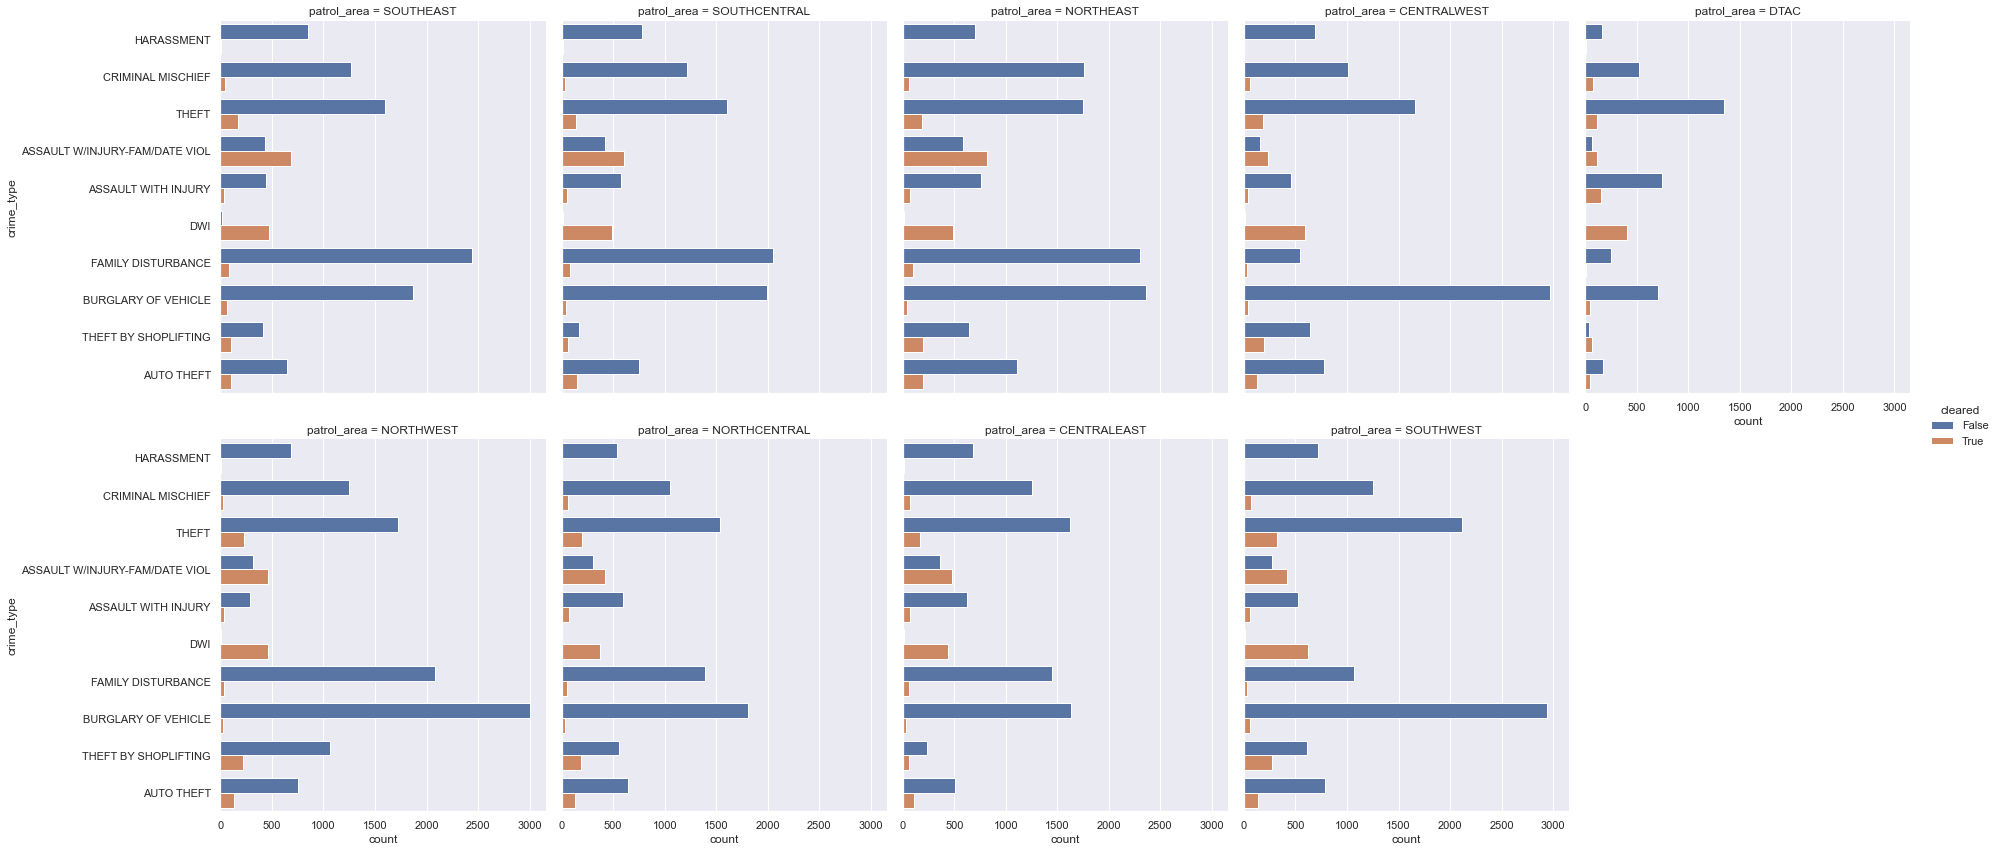

In [77]:
#define plotting region (2 rows, 5 columns)
# fig, axes = plt.subplots(2, 5)
sns.catplot(y='crime_type', hue="cleared", col="patrol_area",
              data=top_crime_df, kind="count",
                height=6, aspect=.9, col_wrap = 5);

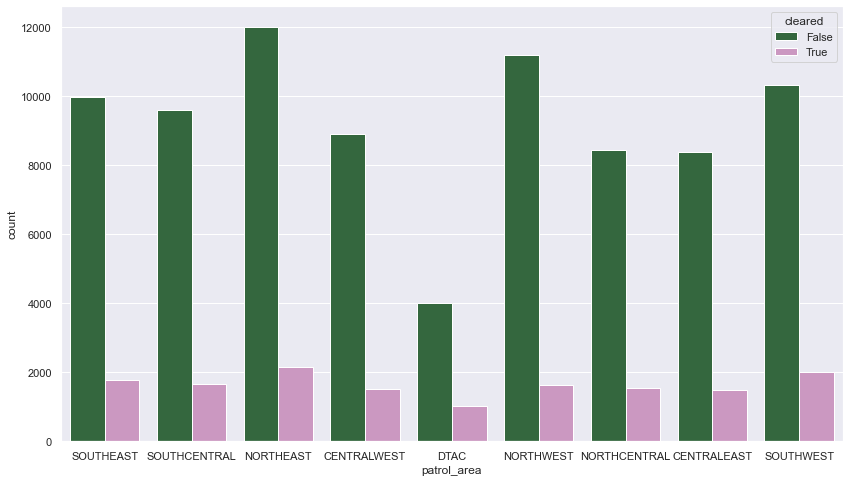

In [136]:
def patrol_area_cleared(top_crime_df):
    sns.countplot(data = top_crime_df, x = 'patrol_area', hue = 'cleared', palette = 'cubehelix')
    sns.set(rc={'figure.figsize':(14, 8)})
    return
patrol_area_cleared(top_crime_df)

In [141]:
train2.cleared.mean()

0.20704310868245293

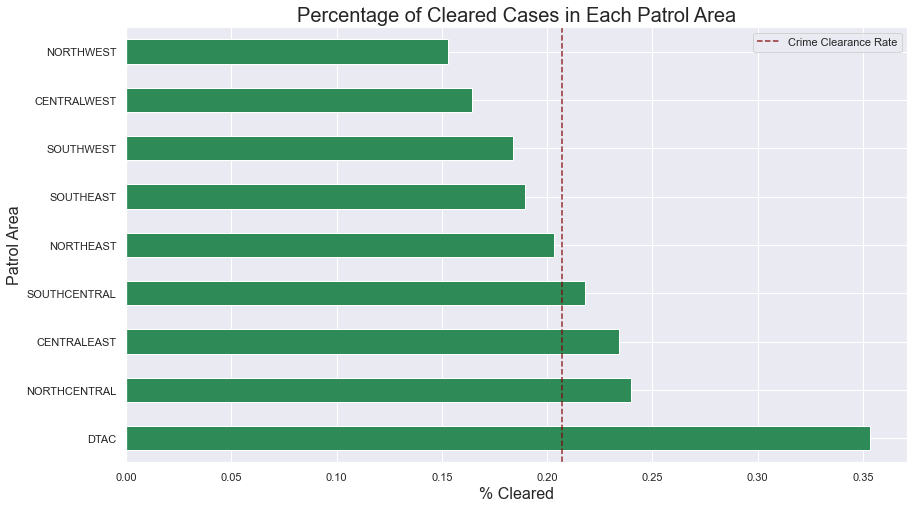

In [155]:
def district_cleared(train2):
    patrol_clearance_rate = train2.cleared.mean()
    df1 = pd.DataFrame(train2.groupby('patrol_area').cleared.mean().sort_values(ascending = False))
    ax = df1.plot.barh(color = 'seagreen')
    plt.ylabel('Patrol Area', fontsize = 16)
    plt.xlabel('% Cleared', fontsize = 16)
    plt.title('Percentage of Cleared Cases in Each Patrol Area', fontsize = 20)
    plt.axvline( patrol_clearance_rate, label = 'Crime Clearance Rate', linestyle = '--', alpha = .8, color = 'maroon')
    plt.legend(['Crime Clearance Rate'])
    return 
district_cleared(train2)

# Family Violence dataset

In [78]:
fv = train1.copy()
fv = train1[train1['family_violence'] == 'Y']
fv = fv.set_index('occurrence_time').sort_index()
fv.shape

(15901, 25)

In [79]:
fv['month'] = fv.index.month_name()
fv['day'] = fv.index.day_name()
fv['year'] = fv.index.year

In [80]:
fv.head()

,crime_type,family_violence,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,latitude,longitude,clearance_status,clearance_date,cleared,time_to_report,the_geom,district_name,battalion_id,code,battalion_code,bureau_name,patrol_area,shape_area,shape_length,month,day,year
occurrence_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,POSS OF FIREARM BY FELON,Y,2018-01-01,2018-01-31 13:09:00,2018-01-31,RESIDENCE / HOME,11513 FAST HORSE DR,78759.0,6.0,ADAM,30.411489,-97.741554,not cleared,2019-01-22,False,30 days 13:09:00,MULTIPOLYGON (((-97.697570539954 30.4059761209...,ADAM 2,21,1273,A1,NORTH,NORTHWEST,7.158634e+07,47622.336711,January,Monday,2018
2018-01-01 00:05:00,ASSAULT W/INJURY-FAM/DATE VIOL,Y,2018-01-01,2018-01-01 00:05:00,2018-01-01,RESIDENCE / HOME,301 BRAZOS ST,78701.0,9.0,GEORGE,30.265055,-97.742241,cleared by arrest,2018-01-01,True,0 days 00:00:00,"MULTIPOLYGON (((-97.735827442287 30.264063289,...",GEORGE 3,194,1299,G1,NORTH,DTAC,8.371570e+06,14491.846845,January,Monday,2018
2018-01-01 01:00:00,AGG ASLT STRANGLE/SUFFOCATE,Y,2018-01-01,2018-01-06 20:18:00,2018-01-06,RESIDENCE / HOME,10610 MORADO CIR,78759.0,10.0,ADAM,30.403906,-97.752324,not cleared,2018-01-12,False,5 days 19:18:00,MULTIPOLYGON (((-97.761817598688 30.4304082646...,ADAM 7,21,1270,A1,NORTH,NORTHWEST,3.060758e+08,162272.848303,January,Monday,2018
2018-01-01 01:01:00,FELONY ENHANCEMENT/ASSLT W/INJ,Y,2018-01-01,2018-01-01 01:01:00,2018-01-01,RESIDENCE / HOME,2302 E WILLIAM CANNON DR,78744.0,2.0,FRANK,30.186692,-97.758146,cleared by arrest,2018-01-01,True,0 days 00:00:00,MULTIPOLYGON (((-97.751209649699 30.1827262170...,FRANK 8,184,1295,F1,SOUTH,SOUTHEAST,7.418097e+07,48101.055141,January,Monday,2018
2018-01-01 02:15:00,AGG ASLT STRANGLE/SUFFOCATE,Y,2018-01-01,2018-01-01 02:15:00,2018-01-01,RESIDENCE / HOME,8701 ESCARPMENT BLVD,78749.0,8.0,DAVID,30.212219,-97.875499,not cleared,2018-01-25,False,0 days 00:00:00,MULTIPOLYGON (((-97.854395318936 30.2247304224...,DAVID 7,164,1286,D1,SOUTH,SOUTHWEST,1.570599e+08,62761.932667,January,Monday,2018


In [83]:
fv[fv.clearance_status == 'not cleared'].patrol_area.value_counts()

NORTHEAST       1537
SOUTHEAST       1377
SOUTHCENTRAL    1333
CENTRALEAST     1153
NORTHWEST        904
NORTHCENTRAL     828
SOUTHWEST        812
CENTRALWEST      577
DTAC             166
Name: patrol_area, dtype: int64

In [85]:
fv[fv.clearance_status == 'not cleared'].crime_type.value_counts().head(10)

ASSAULT W/INJURY-FAM/DATE VIOL    2786
HARASSMENT                        1600
ASSAULT BY CONTACT FAM/DATING     1492
ASSAULT BY THREAT FAM/DATING       420
AGG ASLT STRANGLE/SUFFOCATE        414
AGG ASSAULT FAM/DATE VIOLENCE      328
ASSAULT BY CONTACT                 290
TERRORISTIC THREAT-FAM/DAT VIO     261
ASSAULT BY THREAT                  167
TERRORISTIC THREAT                 115
Name: crime_type, dtype: int64

In [86]:
fv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15901 entries, 2018-01-01 00:00:00 to 2021-12-31 21:49:00
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   crime_type        15901 non-null  object         
 1   family_violence   15901 non-null  object         
 2   occurrence_date   15901 non-null  datetime64[ns] 
 3   report_time       15901 non-null  datetime64[ns] 
 4   report_date       15901 non-null  datetime64[ns] 
 5   location_type     15901 non-null  object         
 6   address           15901 non-null  object         
 7   zip_code          15901 non-null  float64        
 8   council_district  15901 non-null  float64        
 9   sector            15901 non-null  object         
 10  latitude          15901 non-null  float64        
 11  longitude         15901 non-null  float64        
 12  clearance_status  15901 non-null  object         
 13  clearance_date    15901 no

<AxesSubplot:>

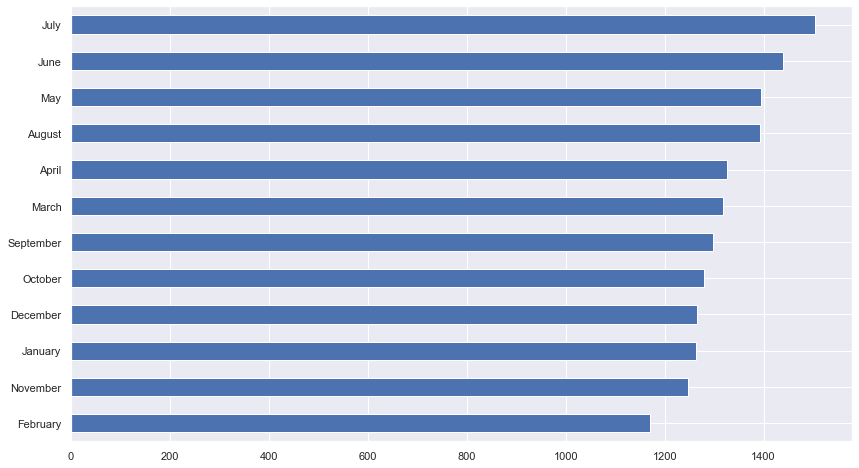

In [87]:
fv.month.value_counts().sort_values().plot.barh()

<AxesSubplot:ylabel='patrol_area'>

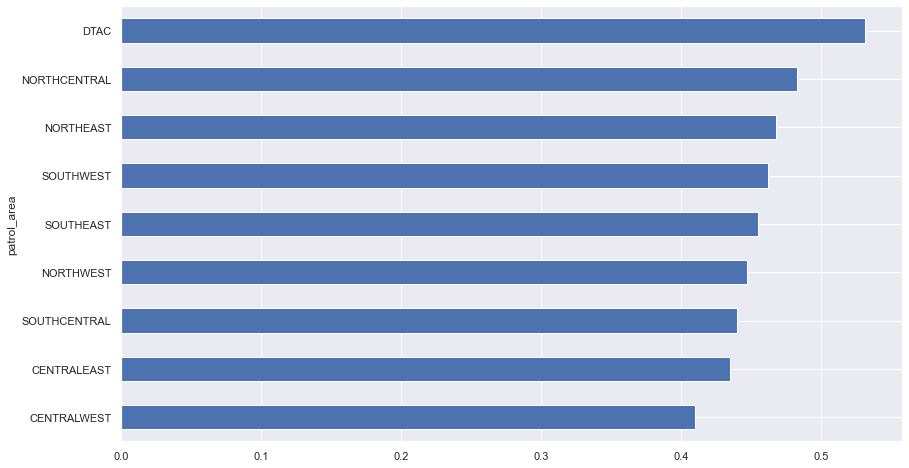

In [130]:
fv.groupby('patrol_area').cleared.mean().sort.plot.barh()

<AxesSubplot:>

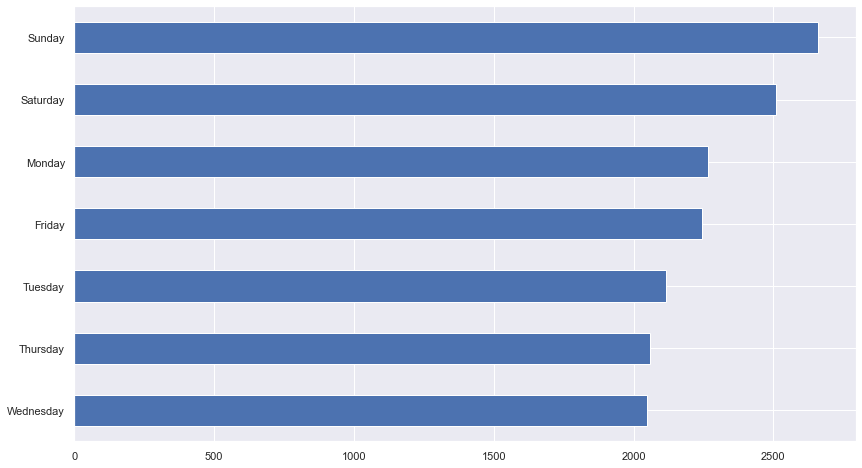

In [89]:
fv.day.value_counts().sort_values().plot.barh()

# Takeaways
- higher than average counts fall into the top 5 districts 2,1,4,3,5
- most 'not cleared' family violence crimes are assualt w/injury, harassment, assault by contact
- family violence was highest during 2020, occuring during the pandemic and lockdowns.
- Summer months have the highest reports of family violence
- Saturday and sunday have the highest occurences of family violence reports
- Monday, is the highest during the work week
-- Council Districts 4,3,1 have the highest counts of family violence